<h1>Data Validation</h1>

In [97]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)

In [98]:
df = pd.read_csv('main_raw.csv')
df = df.sort_values(by='date')
df.drop('Unnamed: 0',axis=1,inplace=True) #Drop index duplicate column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133713 entries, 0 to 31224
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   volume                133713 non-null  float64
 1   timestamp             133713 non-null  int64  
 2   1d_return             133713 non-null  float64
 3   Ticker                133713 non-null  object 
 4   op_close              133644 non-null  float64
 5   return_target         133644 non-null  float64
 6   1d_intraday_return    133644 non-null  float64
 7   1d_afterhours_return  133644 non-null  float64
 8   2d_return             133326 non-null  float64
 9   3d_return             133087 non-null  float64
 10  4d_return             132865 non-null  float64
 11  5d_return             132696 non-null  float64
 12  6d_return             132534 non-null  float64
 13  7d_return             132379 non-null  float64
 14  8d_return             132243 non-null  float64
 15  9

<h1>(1): Clean Data</h1>
<h3>Drop rows with nan values in return_target, op_close(indicates data error)</h3>

In [99]:
current_length = len(df)
#1d return
df.dropna(subset='op_close',inplace=True)
print(f'op_close: {current_length-len(df)} observations removed')
current_length = len(df)
#return target
df.dropna(subset='return_target',inplace=True)
print(f'return target: {current_length-len(df)} observations removed')
len(df)

op_close: 69 observations removed
return target: 0 observations removed


133644

<h1>(2): Test Data Normality</h1>

count    1.336440e+05
mean     3.044922e+06
std      1.471455e+07
min      5.000000e+04
25%      1.939776e+05
50%      5.830755e+05
75%      1.883766e+06
max      1.177670e+09
Name: volume, dtype: float64
count    1.336440e+05
mean     1.644120e+12
std      1.755802e+10
min      1.609823e+12
25%      1.630469e+12
50%      1.646802e+12
75%      1.657598e+12
max      1.672376e+12
Name: timestamp, dtype: float64
count    133644.000000
mean         -0.081930
std           0.045897
min          -0.954300
25%          -0.089000
50%          -0.069000
75%          -0.057600
max          -0.050000
Name: 1d_return, dtype: float64
count     133644
unique      5893
top         LABU
freq         135
Name: Ticker, dtype: object
count    133644.000000
mean         36.264388
std         115.398156
min           0.068650
25%           5.020000
50%          13.260000
75%          33.550000
max       16000.000000
Name: op_close, dtype: float64
count    133644.000000
mean          0.002233
std           

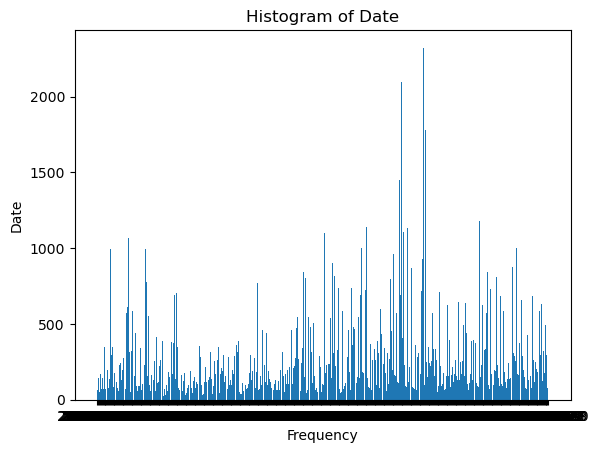

In [100]:
#Basic descriptive stats for each column
for col in df.columns:
    print(df[col].describe())

#Ticker - checking for large number of unique values
print(f"Unique Tickers: {len(df['Ticker'].unique())}")

#Dates - checking for relatively uniform distribution
plt.hist(df['date'],bins=550)
plt.title('Histogram of Date')
plt.xlabel('Frequency')
plt.ylabel('Date')
plt.show()

<h1>(3): Remove Outliers</h1>
<h3>Create z-scores for continuos variables, outlier threshhold is abs(z-score) > 5</h3>
<h3>Values greater than outlier threshold are replaced with np.nan</h3>

In [101]:
def z_outliers(dataframe, col, zmax):
    df = dataframe.copy()
    mean = np.nanmean(df[col])
    std = np.nanstd(df[col])
    df['z_score'] = (df[col] - mean) / std
    df.loc[df['z_score'].abs() > zmax, col] = np.nan
    return df[col]

for col in ['1d_return','return_target', '1d_intraday_return', '1d_afterhours_return','2d_return', '3d_return', '4d_return', '5d_return', '6d_return','7d_return', '8d_return', 
            '9d_return', '10d_return', '15d_return','20d_return', '2h_return', '1h_return']:
    print(col)
    descdf = pd.DataFrame(df[col].describe())
    descdf.rename(columns={col: 'Pre-Filter'}, inplace=True)
    df[col] = z_outliers(df,col,5) #setting z-score max high because of long distirbution tails 
    descdf['Post-Filter'] = df[col].describe()
    print(descdf)

1d_return
          Pre-Filter    Post-Filter
count  133644.000000  132781.000000
mean       -0.081930      -0.079595
std         0.045897       0.034130
min        -0.954300      -0.311400
25%        -0.089000      -0.088400
50%        -0.069000      -0.068800
75%        -0.057600      -0.057600
max        -0.050000      -0.050000
return_target
          Pre-Filter    Post-Filter
count  133644.000000  133591.000000
mean        0.002233       0.001514
std         0.126633       0.033824
min        -0.740000      -0.584800
25%        -0.011000      -0.011000
50%         0.000000       0.000000
75%         0.012900       0.012900
max        43.702000       0.625700
1d_intraday_return
          Pre-Filter    Post-Filter
count  133644.000000  133073.000000
mean       -0.064871      -0.063943
std         0.043051       0.037462
min        -0.947500      -0.280000
25%        -0.079600      -0.079400
50%        -0.059600      -0.059500
75%        -0.043800      -0.043800
max         0.905700 

In [102]:
df.to_csv('main.csv')